In [ ]:
# base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных (colab)

In [ ]:
import gdown

url = "https://drive.google.com/file/d/1a9eo-9XzqZ1XFBaqfJHdecoB-oG-ch5B/view?usp=sharing"
output = "data.zip"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1a9eo-9XzqZ1XFBaqfJHdecoB-oG-ch5B
From (redirected): https://drive.google.com/uc?id=1a9eo-9XzqZ1XFBaqfJHdecoB-oG-ch5B&confirm=t&uuid=bb045e79-e99f-4245-aeda-f025e311a029
To: /content/data.zip
100%|██████████| 26.6M/26.6M [00:00<00:00, 50.7MB/s]


'data.zip'

In [ ]:
!mkdir data
!mkdir data/raw

In [ ]:
!unzip data.zip -d data/raw

Archive:  data.zip
  inflating: data/raw/data_final_for_dls_new.jsonl  
  inflating: data/raw/data_final_for_dls_eval_new.jsonl  


In [ ]:
!rm data.zip

In [ ]:
data_eval = pd.read_json("data/raw/data_final_for_dls_eval_new.jsonl", lines=True)
data = pd.read_json("data/raw/data_final_for_dls_new.jsonl", lines=True)

data.drop(columns='relevance', inplace=True)
data_eval.drop(columns='relevance', inplace=True)

data.rename(columns={'relevance_new': 'relevance'}, inplace=True)
data_eval.rename(columns={'relevance_new': 'relevance'}, inplace=True)

# 0. Проведем небольшой EDA


In [ ]:
data.sample(5)

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,relevance
12006,фанера ламинированная бакелитовая 20 мм,"Санкт-Петербург, улица Латышских Стрелков, 31В",Гелиос ТД; Gelios Th; Торговый дом Гелиос; Gel...,Фанера,1056670180,Компания «Гелиос ТД» предлагает широкий ассорт...,Организация занимается продажей фанеры и други...,0.0
761,пивной ресторан на воронцовской улице,"Москва, улица Александра Солженицына, 2А",Гусятникоff; Gusyatnikoff,Ресторан,91649396341,Ресторан «Гусятникоff» предлагает широкий выбо...,"Организация занимается ресторанным бизнесом, п...",0.0
19444,печать фотографии,"Москва, улица Куусинена, 2, корп. 1",Белка; Photo; Студия Белка,Фотоуслуги,40176634180,"Организация предоставляет фотоуслуги, полиграф...","Организация предоставляет фотоуслуги, копирова...",0.0
1575,грузинский ресторан на баррикадной,"Москва, 2-я Брестская улица, 39с2",Хинкальная; Khinkalnaya,Кафе,19923205586,Хинкальная предлагает разнообразные блюда груз...,Организация занимается подачей грузинской кухн...,0.0
1452,анализ на коклюш,"Московская область, Мытищи, улица Матросова, 1...",Деломедика; Delomedika; DиамеD; Медицинский це...,"Медцентр , клиника",46797812259,Медицинская клиника «Деломедика» предоставляет...,Организация занимается проведением медицинских...,0.0


In [ ]:
data_eval.sample(5)

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,relevance
477,уз газойл,"Красноярский край, Ачинск, улица 5 Июля, 3Б",Газойл; Gazoil; АЗС,"АГНС , АГЗС , АГНКС",31615398444,None,Организация занимается заправкой автомобилей г...,0.0
48,адрес налоговой инспекции по адресу проживания,"Самарская область, Тольятти, 19-й квартал, бул...",Межрайонная ИФНС России № 2 по Самарской облас...,Налоговая инспекция,161415387632,None,Организация занимается обслуживанием налогопла...,1.0
303,дод тюмень,"Тюмень, Комбинатская улица, 38",МАУ ДО ДЮЦ Фортуна; Maou Dod Detsko-yunoshesky...,Дополнительное образование,1027113004,None,Организация занимается дополнительным образова...,1.0
7,аэс,"Республика Дагестан, Гунибский район, сельское...",Гунибская ГЭС,"АЭС , ГЭС , ТЭС",90012870962,None,Организация занимается эксплуатацией гидроэлек...,0.0
490,утилизация шин в спб,"Санкт-Петербург, Пулковское шоссе, 43, корп. 1",Две атмосферы; Dve atmosfery,Шиномонтаж,126523788247,Организация предоставляет услуги по шиномонтаж...,"Организация занимается шиномонтажом, ремонтом ...",1.0


#### Что означают колонки:

In [ ]:
data.sample(1).T.to_dict()

{30991: {'Text': 'рок атрибутика',
  'address': 'Москва, проспект Мира, 211к2',
  'name': 'Tezenis; Tezenis underwear',
  'normalized_main_rubric_name_ru': 'Магазин нижнего белья',
  'permalink': 1137496204,
  'prices_summarized': None,
  'reviews_summarized': 'Организация занимается продажей нижнего белья, трикотажа и одежды. Отзывы смешанные: есть положительные оценки качества товаров и работы консультантов, но также много критики навязчивого поведения персонала и проблем с сервисом. | 1. Положительный отзыв без деталей | 2. Критикуют отсутствие возврата и проблемы с обслуживанием | 3. Отзыв о переменчивом выборе и навязчивых продавцах | 4. Хвалят хороший выбор и консультантов | 5. Положительный отзыв о качестве белья и выборе | 6. Критикуют недоброжелательного консультанта и дефекты товаров | 7. Хвалят персонал и акции | 8. Критикуют персонал и подход к клиентам | 9. Критикуют поведение сотрудников и навязчивость | 10. Критикуют навязчивых продавцов | 11. Критикуют неактуальную инфо

In [ ]:
print(f"Всего уникальных запросов в данных: {data['Text'].nunique()} из {len(data)}")

Всего уникальных запросов в данных: 9332 из 35094


In [ ]:
data.sample(5)['Text'].to_list()

['ресторан вегетарианской пицца доставка',
 'автозапчасти на ваз',
 'итальянское кафе в жулебино',
 'детская стоматология',
 'плетеные короба для магазинов']

In [ ]:
data[data['Text'] == data.sample(1)['Text'].to_list()[0]]

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,relevance
2025,ресторан для романтического ужина,"Москва, Мироновская улица, 33, стр. 28",Сим-Сим; Sim-Sim; Ресторан Сим Сим; Сим Сим; С...,Ресторан,67642409123,None,Организация «Сим-Сим» предлагает блюда кавказс...,1.0
3792,ресторан для романтического ужина,"Москва, улица Охотный Ряд, 2",Goodman; Goo; Goodman Стейк-Хаус; Steak House ...,Ресторан,1219538688,Ресторан Goodman предлагает широкий выбор блюд...,"Goodman — ресторан в центре Москвы, известный ...",1.0
4263,ресторан для романтического ужина,"Москва, Цветной бульвар, 2",Probka; Пробка; Кафе Probka; Пробка на Цветном...,Ресторан,1231611587,Ресторан Probka предлагает широкий выбор блюд ...,Организация занимается ресторанным обслуживани...,1.0
17673,ресторан для романтического ужина,"Москва, Большая Никитская улица, 15, стр. 1",She; SHE,Ресторан,87650811955,Ресторан She предлагает широкий выбор блюд: за...,"Организация She — это ресторан с баром, которы...",1.0
20557,ресторан для романтического ужина,"Москва, Таганская улица, 29с1",Мандарин; Mandarin; Mandarin Мандарин; S Dым. ...,Ресторан,235240066628,Ресторан «Мандарин» предлагает широкий выбор б...,"Организация занимается ресторанным бизнесом, п...",1.0
26775,ресторан для романтического ужина,"Москва, Малый Черкасский переулок, 2",Mandarin Combustible; Mandarin; Мандарин бар; ...,Ресторан,25747942664,Ресторан предлагает разнообразные блюда азиатс...,Организация занимается предоставлением услуг в...,1.0
30612,ресторан для романтического ужина,"Московская область, Одинцово, Подушкинское шос...",Ресторан Загородный очаг; Restaurant Zagorodny...,Ресторан,132865706832,Ресторан «Загородный очаг» предлагает разнообр...,"Организация занимается ресторанным бизнесом, п...",1.0


Оценки
* 1.0 => "RELEVANT_PLUS" - релевантное заведение. Занчение 1.0
* 0.1 => "RELEVANT_MINUS" — в целом может быть релевантна, если нет других вариантов получше. Например, по запросу "Кофе" показать не кофейню, а условный вкусвилл с кафе
* 0.0 => "IRRELEVANT" - не подходит под запрос

Nan'ы

In [ ]:
data.isna().sum()

,0
Text,0
address,0
name,0
normalized_main_rubric_name_ru,0
permalink,0
prices_summarized,14465
reviews_summarized,1539
relevance,0


### Посмотрим на распределения классов.

In [ ]:
print(f"Всего уникальных запросов в данных: {data['Text'].nunique()} из {len(data)}")

Всего уникальных запросов в данных: 9332 из 35094


#### 1. Полное распределение классов.

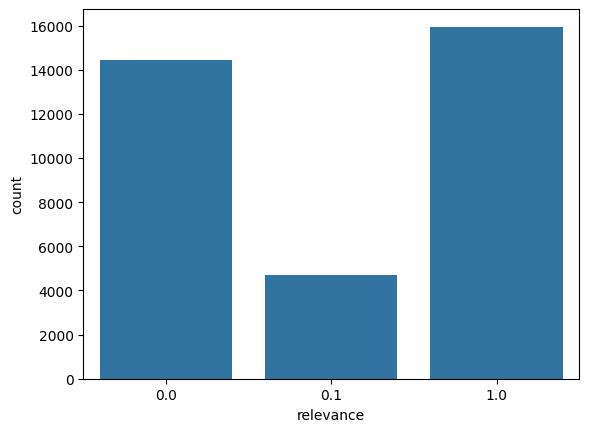

1.0 :15950 (45.45%)
0.1 :4703 (13.40%)
0.0 :14441 (41.15%)


In [ ]:
sns.countplot(data=data, x='relevance', )
plt.show()
n = len(data)
minus = len(data[data['relevance'] == 0.1])
plus = len(data[data['relevance'] == 1.0])
irr = len(data[data['relevance'] == 0.0])
print(f"1.0 :{plus} ({plus/n * 100:.2f}%)")
print(f"0.1 :{minus} ({minus/n * 100:.2f}%)")
print(f"0.0 :{irr} ({irr/n * 100:.2f}%)")

#### 2. Распределение классов для каждого заведения

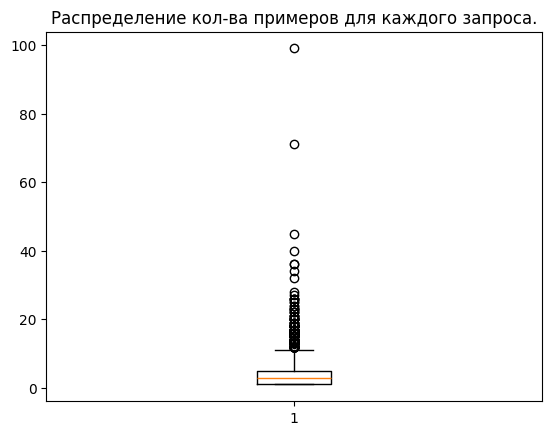

In [ ]:
counts = data.groupby('Text').size().reset_index(name='count')
plt.boxplot(counts['count'])
plt.title("Распределение кол-ва примеров для каждого запроса.")
plt.show()

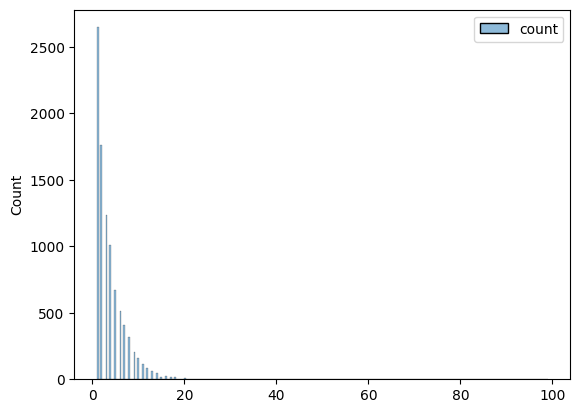

In [ ]:
sns.histplot(data=counts)
plt.show()

# Написание бейзлайна (2 балла)

Что вообще должен из себя представлять бейзлайн?

1) Дообучить Классификатор на трансформере.
2) Тупо запрос в LLM
Реализуем обе этих тактики, посмотрим на результат.


## 1. Дообучение классификатора на трансформере.

In [ ]:
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import ExponentialLR
from torch import Tensor

from tqdm.notebook import tqdm
from omegaconf import DictConfig
from sklearn.metrics import f1_score

from transformers import AutoTokenizer, AutoModel

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

### 1.1 Подготовка данных.

### Работа с длинами текстов.



In [ ]:
def make_object_text(row):
    return (
        f"Запрос: {row['Text']}.\n"
        f"Название: {row['name']}\n"
        f"Рубрика: {row['normalized_main_rubric_name_ru']}\n"
        f"Адрес: {row['address']}\n"
        f"Цены: {row['prices_summarized']}\n"
        f"Отзывы: {row['reviews_summarized']}"
    )

document = data.apply(make_object_text, axis=1)
# document_val = data_eval.apply(make_object_text, axis=1)

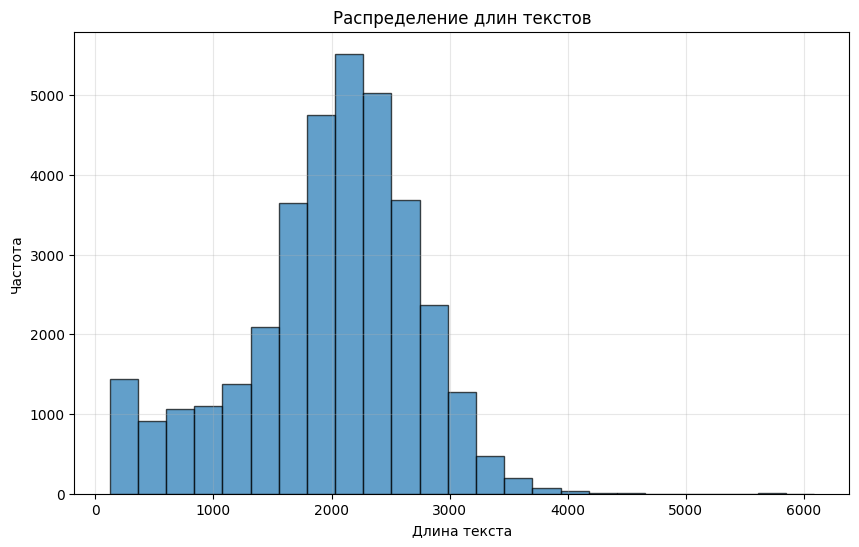

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(document.apply(len), bins=25, edgecolor='black', alpha=0.7)
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.grid(alpha=0.3)
plt.show()

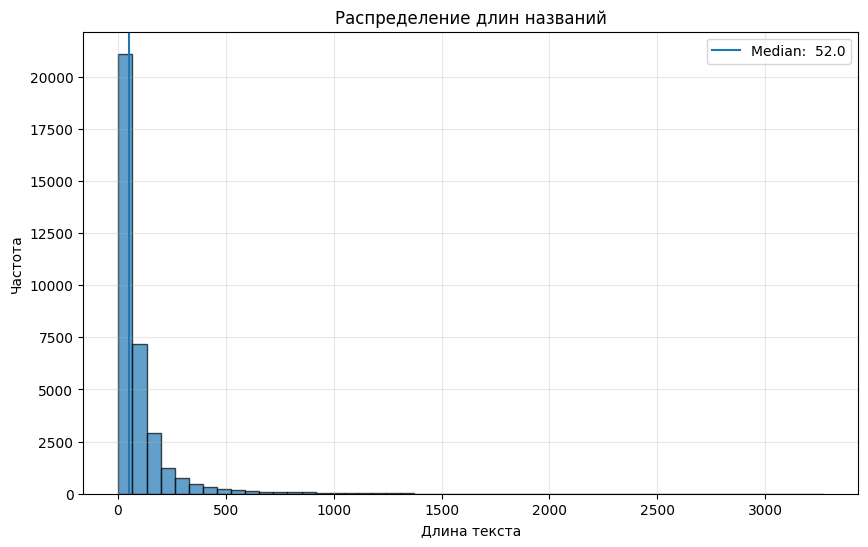

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['name'].apply(len), bins=50, edgecolor='black', alpha=0.7)
plt.axvline(np.quantile(data['name'].apply(len), 0.5), label=f"Median:  {np.median(data['name'].apply(len))}")
plt.title('Распределение длин названий')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Заметим, что тексты весьма длинные. Модель будет тяжело обучать, поэтому тексты придется обрезать. Проанализруем данные и веберем стратегрию обрезки текстов.

In [ ]:
print(*document.sample(1).to_list())

Запрос: магазины одежды и обуви.
Название: Plaxa; Plaxa+
Рубрика: Магазин одежды
Адрес: Мурманск, Кольский проспект, 158к1
Цены: None
Отзывы: Организация занимается продажей одежды. Отзывы положительные: пользователи хвалят стиль и качество одежды. | 1. Хвалят хорошую и стильную одежду | 2. Отмечают крутой ассортимент одежды | 3. Считают магазин одним из лучших в Мурманске для современной мужской одежды


* После небольшого просмотра заметим, что в графе Цены сначала идет краткое описание организации, а потом через | перечисляются ключевые слова - их можно убрать либо отставить например первые 5

* С отзывами тоже самое, но там мы не будем брать что либо после | так как в целом отзывы не особо сильно несут информации и первой строчки будет достаточно.
Заметим также, что есть отзывы без | - просто с пунктами, мы их будем тогда сплитить по \n
* Также названия - Заметим, что у одного заведения много вариантов названий. Обрежем их тоже, взяв например 5 разных вариантов (они перечислены через ;)


In [ ]:
def make_object_text(row):
    names_num = 5
    prices_num = 5
    # names
    if row['name'] != None:
        name_splitted = row['name'].split(';')
        len_split = min(names_num, len(name_splitted))
        names_take = " ; ".join(name_splitted[:len_split])
    else:
        names_take = None


    # take prices
    if row['prices_summarized'] != None:
        prices_splited = row['prices_summarized'].split('|')
        len_split = min(prices_num + 1, len(prices_splited))
        prices_take = " | ".join(prices_splited[:len_split])
    else:
        prices_take = None

    # take reviews
    if row['reviews_summarized'] != None:
        rev_splited = row['reviews_summarized'].split('|')
        rev_take = rev_splited[0]

        # then split by \n
        rev_splited = rev_take.split('\n')
        rev_take = rev_splited[0]
    else:
        rev_take = None

    return (
        f"Запрос: {row['Text']}.\n"
        f"Название: {names_take}\n"
        f"Рубрика: {row['normalized_main_rubric_name_ru']}\n"
        f"Адрес: {row['address']}\n"
        f"Цены: {prices_take}\n"
        f"Отзывы: {rev_take}"
    )

document = data.apply(make_object_text, axis=1)
document_val = data_eval.apply(make_object_text, axis=1)

Посмотрим что получилось:

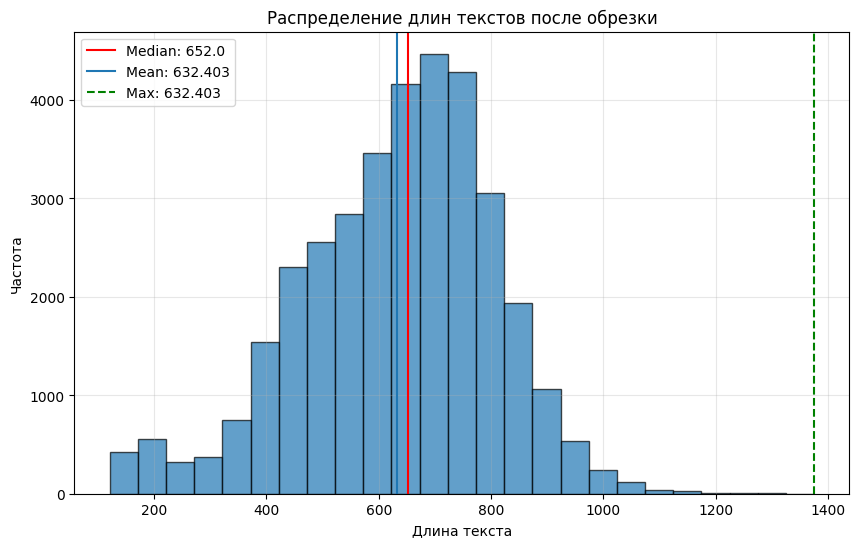

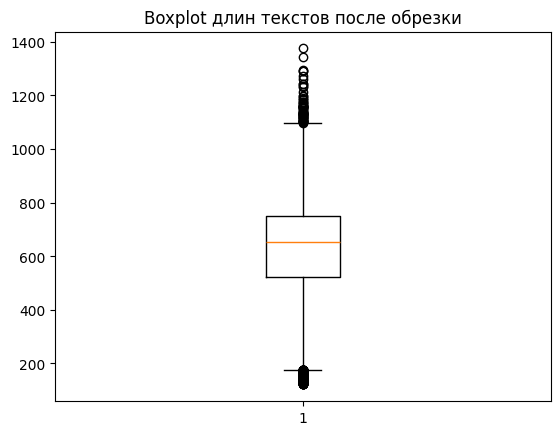

In [ ]:
doc_len = document.apply(len)
plt.figure(figsize=(10, 6))
plt.hist(doc_len, bins=25, edgecolor='black', alpha=0.7)
plt.axvline(np.median(doc_len), label=f"Median: {round(np.median(doc_len), 3)}", color='r')
plt.axvline(np.mean(doc_len), label=f"Mean: {round(np.mean(doc_len), 3)}")
plt.axvline(np.max(doc_len), label=f"Max: {round(np.mean(doc_len), 3)}", color='green', linestyle='--')
plt.title('Распределение длин текстов после обрезки')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.boxplot(doc_len)
plt.title('Boxplot длин текстов после обрезки')
plt.show()

In [ ]:
doc_len.describe().T

,0
count,35094.000000
mean,632.402718
std,172.271712
min,121.000000
25%,521.000000
50%,652.000000
75%,751.000000
max,1375.000000


In [ ]:
taken = document[document.str.len() > 1200]

print(*taken.sample(1).to_list())

Запрос: СПб ГБУ «Городской центр социальных программ и профилактики асоциальных явлений среди молодежи «КОНТАКТ».
Название: СПб ГБУ Городской центр социальных программ и профилактики асоциальных явлений среди молодежи Контакт Отдел социального сопровождения несовершеннолетних правонарушителей на территории Кировского района ;  Otdel sotsialnogo soprovozhdeniya nesovershennoletnikh pravonarushiteley Gorodskoy tsentr Sotsialnykh Programm i Profilaktiki Asotsialnykh Yavleny Sredi Molodezhi Kontakt ;  Центр социальных программ и профилактики асоциальных явлений среди молодежи Контакт, отдел социального сопровождения несовершеннолетних правонарушителей на территории, Кировский район ;  Городской центр Социальных Программ и Профилактики Асоциальных Явлений Среди Молодежи - Контакт ;  Отдел социального сопровождения несовершеннолетних правонарушителей
Рубрика: Социальная служба
Адрес: Санкт-Петербург, улица Гладкова, 43
Цены: None
Отзывы: Организация занимается социальным сопровождением несов

Вывод: получилось хорошо уменьшить размер данных не потеряв важной информации. Будем обрезать тексты на токены по размеру 1024. Проверим на каком нибудь токенизаторе:

In [ ]:
# from sentence_transformers import SentenceTransformer
# EMBEDDING_MODEL_NAME = "Qwen/Qwen3-Embedding-0.6B"

# print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}")

# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
# lengths = [len(tokenizer.encode(doc_str)) for doc_str in document]

# # Построим график распределения длин документов, подсчитываемых как количество токенов
# fig = pd.Series(lengths).hist(edgecolor='black', bins=30, alpha=0.7)
# plt.figure(figsize=(10, 6))
# plt.title("Распределение длин документов в количестве токенов")
# plt.show()

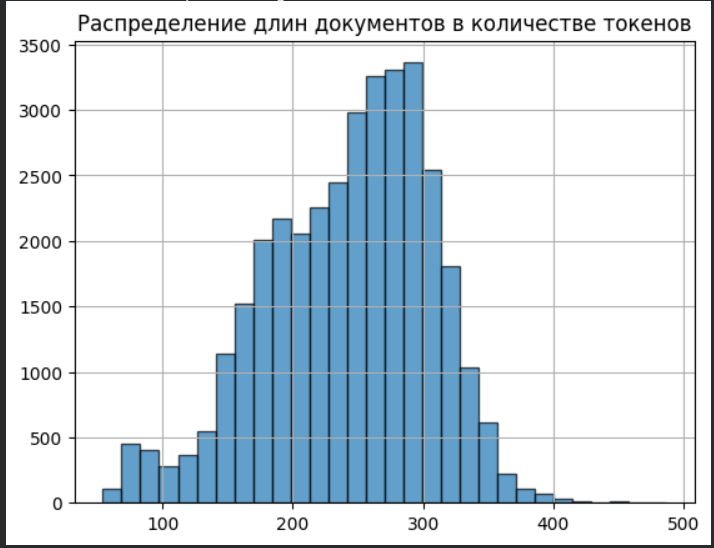

### Лейблы

In [ ]:
ind2label = {0:0.0, 1:1.0, 2:0.1}
label2ind = {0.0:0, 1.0:1, 0.1:2}

relevances = data['relevance'].map(label2ind)
relevances_val = data_eval['relevance'].map(label2ind)

### Датасет

In [ ]:
from collections import defaultdict
class OrgDataset(Dataset):
    def __init__(self, df, relevances, tokenizer, max_len):
        # data
        self.data = df.to_list()
        self.targets = relevances.to_list()
        # tokenizer
        self.tokenizer = tokenizer
        self.max_len = max_len
        # do tokenizing

        self.tokenized_data = tokenizer(
            self.data,
            padding=False,
            truncation=True,
            max_length=self.max_len
        )


    def __getitem__(self, idx):
        # Get text and label for this text
        label = self.targets[idx]

        item_tokenized_dict = dict()
        # Get dict itemstokenizer
        for key in self.tokenized_data.keys():
            item_tokenized_dict[key] = self.tokenized_data[key][idx]


        return item_tokenized_dict, label

    def __len__(self):
        return len(self.data)

class Colator:
    def __init__(self, tokenizer, is_left_padding=True):
        self.pad_token = tokenizer.pad_token_id
        self.left_padding = is_left_padding

    def __call__(self, batch):
        """
        batch - list of tupels
        we take text, targets
        targets -> torch tensor

        texts we do padding from left
        """
        texts_dict, targets = zip(*batch)

        # padding from left

        batch_dict = defaultdict(list)
        keys = texts_dict[0].keys()

        max_len_batch = max([len(text['input_ids']) for text in texts_dict])

        for dct in texts_dict:
            need = max_len_batch - len(dct['input_ids'])
            for key in keys:

                token = None
                if key == 'input_ids':
                    token = self.pad_token
                else:
                    token = 0


                if self.left_padding:
                    seq = dct[key] if need <= 0 else ([token] * need  + dct[key])
                else:
                    seq = dct[key] if need <= 0 else (dct[key] + [token] * need)

                batch_dict[key].append(seq)

        # To Tensors
        for key in batch_dict:
            batch_dict[key] = torch.tensor(batch_dict[key], dtype=torch.long)

        targets = torch.tensor(targets, dtype=torch.long)


        return batch_dict, targets

Создание датасетов и загрузка модели

### Model Class

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, base_model: str, n_classes, is_left_padding=True):
        super().__init__()
        # params
        self.left_padding = is_left_padding

        # 1) BackBone
        self.backbone = AutoModel.from_pretrained(base_model)

        # 2) Cls Head
        hidden_size = self.backbone.config.hidden_size

        self.head = nn.Sequential(
             nn.Linear(hidden_size, hidden_size),
             nn.ReLU(),
             nn.Dropout(0.2),
             nn.LayerNorm(hidden_size),
             nn.Linear(hidden_size, n_classes)
        )

    def last_token_pool(self, last_hidden_states: Tensor) -> Tensor:
        if self.left_padding:
            return last_hidden_states[:, -1]
        else:
            return last_hidden_states[:,  0]

            # sequence_lengths = attention_mask.sum(dim=1) - 1
            # batch_size = last_hidden_states.shape[0]
            # return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

    # def average_pool(self, last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    #     last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    #     return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

    def forward(self, **input_batch):
        # get model outputs
        model_outputs = self.backbone(**input_batch)
        # get [CLS] embeddings
        cls_embeddings = self.last_token_pool(model_outputs.last_hidden_state)

        head_outputs = self.head(cls_embeddings)

        return head_outputs

In [ ]:
def freeze_backbone_function(model: TransformerModel):
    # разморозим всё
    for p in model.parameters():
        p.requires_grad = True

    # заморозим только backbone
    for p in model.backbone.parameters():
        p.requires_grad = False

    return model


### Metrics methods

В работе будем использовать accuracy, f1

### Train Methods


In [ ]:
basic_config = {
    "LR": 3e-4,
    "DECAY": 1e-6,
    "NAME": "baseline_classifier",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "SCHED_GAMMA": 0.97,
    "SAVE_DIR": "models",
    "SAVE_BEST": True,
}


def calculate_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate accuracy using basic formula
    """
    if len(y_true) == 0:
        return 0.0
    return float((y_true == y_pred).mean())


class CustomTrainer:
    def __init__(self, config: DictConfig | dict | None = None,
                 freeze_backbone_fn=None,

                 save_dir: str = None,
                 save_best: bool = None,
    ):
        if config is None:
            config = basic_config

        if isinstance(config, DictConfig):
            self.cfg = config
        else:
            self.cfg = DictConfig(config)

        # overrides if passed
        if save_dir is not None:
            self.cfg.SAVE_DIR = save_dir
        if save_best is not None:
            self.cfg.SAVE_BEST = save_best

        self.device = self.cfg.device
        self.freeze_backbone_fn = freeze_backbone_fn

        # will be created in train()
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.scaler = None

        # learning history
        self.history = {
            "train_loss": [],
            "train_f1": [],
            "train_acc": [],
            "val_f1": [],
            "val_acc": [],
        }

    def _prepare_batch(self, batch):
        """
        Метод для переноса батча на устройство.
        """

        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            x, y = batch
            if isinstance(x, dict):
                x = {k: v.to(self.device) for k, v in x.items()}
            else:
                x = x.to(self.device)
            y = y.to(self.device)
            return x, y

        raise TypeError(f"Unsupported batch format: {type(batch)}")

    def train(self, model, trainloader, valloader=None, num_epochs=10, freeze_backbone: bool = True):
        # 1. freeze backbone if needed
        if freeze_backbone:
            model = self.freeze_backbone_fn(model)

        # 2. device
        model = model.to(self.device)

        self.cfg.EPOCHS = num_epochs

        # 3. loss / optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.cfg.LR)

        # 4. scheduler / scaler
        self.scheduler = ExponentialLR(self.optimizer, gamma=float(self.cfg.SCHED_GAMMA))
        self.scaler = torch.amp.GradScaler("cuda") # potential error when cpu (be careful)

        # 5. saving setup
        os.makedirs(self.cfg.SAVE_DIR, exist_ok=True)
        es_best_metrics = -1.0 # best metrics for early stopping

        epoch_bar = tqdm(range(self.cfg.EPOCHS), desc="Epochs", position=0, leave=True)
        for epoch in epoch_bar:
            train_loss, train_f1, train_acc = self.train_one_epoch(
                model=model,
                trainloader=trainloader,
                epoch=epoch,
                epochs=self.cfg.EPOCHS,
            ) # train epoch

            self.history["train_loss"].append(train_loss)
            self.history["train_f1"].append(train_f1)
            self.history["train_acc"].append(train_acc)

            if valloader is not None:
                val_f1, val_acc = self.eval(model, valloader) # evaluation

                self.history["val_f1"].append(val_f1)
                self.history["val_acc"].append(val_acc)
            else:
                val_f1, val_acc = None, None

            # log
            if val_f1 is not None:
                tqdm.write(
                    f"Epoch {epoch+1}/{self.cfg.EPOCHS} "
                    f"| Train loss {train_loss:.4f} | f1 {train_f1:.4f} | acc {train_acc:.4f} "
                    f"| Val f1 {val_f1:.4f} | Val acc {val_acc:.4f}"
                )
            else:
                tqdm.write(
                    f"Epoch {epoch+1}/{self.cfg.EPOCHS} "
                    f"| Train loss {train_loss:.4f} | f1 {train_f1:.4f} | acc {train_acc:.4f}"
                )

            # scheduler step
            self.scheduler.step()

            # save best
            if self.cfg.SAVE_BEST and (val_f1 is not None) and (val_f1 >= es_best_metrics):
                es_best_metrics = val_f1
                best_state = {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": self.optimizer.state_dict(),
                    "val_f1": es_best_metrics,
                    "config": dict(self.cfg),
                }
                torch.save(
                    best_state,
                    os.path.join(self.cfg.SAVE_DIR, f"best_model_{self.cfg.NAME}_{epoch}.pt"),
                )

        if self.device == "cuda":
            torch.cuda.empty_cache()
        return model, self.history

    def train_one_epoch(self, model, trainloader, epoch: int, epochs: int):
        model.train()

        epoch_loss = 0.0
        all_trues = []
        all_preds = []
        all_examples = 0

        progress_bar = tqdm(trainloader, desc=f"Train {epoch+1}/{epochs}", position=1, leave=False)

        for batch in progress_bar:
            self.optimizer.zero_grad(set_to_none=True)

            inputs, labels = self._prepare_batch(batch)

            with torch.amp.autocast(device_type=self.device, dtype=torch.bfloat16):
                logits = model(**inputs)

                loss = self.criterion(logits, labels)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            bs = labels.size(0)
            epoch_loss += loss.item() * bs
            all_examples += bs

            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_trues.extend(labels.detach().cpu().numpy())

            progress_bar.set_postfix(loss=epoch_loss / max(all_examples, 1))

        all_trues = np.array(all_trues)
        all_preds = np.array(all_preds)

        result_loss = epoch_loss / max(all_examples, 1)
        f1_train = f1_score(all_trues, all_preds, average="macro")
        accuracy = calculate_accuracy(all_trues, all_preds)

        return result_loss, f1_train, accuracy

    def eval(self, model, valloader):
        model.eval()
        progress_bar = tqdm(total=len(valloader), unit="step", desc="Val", position=1, leave=False)

        all_trues = []
        all_preds = []
        all_examples = 0

        with torch.no_grad():
            for batch in valloader:
                inputs, labels = self._prepare_batch(batch)

                logits = model(**inputs)

                preds = torch.argmax(logits, dim=-1)

                all_examples += labels.size(0)
                all_preds.extend(preds.detach().cpu().numpy())
                all_trues.extend(labels.detach().cpu().numpy())

                progress_bar.update(1)

        all_trues = np.array(all_trues)
        all_preds = np.array(all_preds)

        f1_val = f1_score(all_trues, all_preds, average="macro")
        accuracy = calculate_accuracy(all_trues, all_preds)

        return float(f1_val), float(accuracy)

    def plot_training_history(self, print_results=True):
        """
        Строит графики обучения из history


            self.history (dict): словарь с историей обучения, содержащий:
                - train_loss: список лоссов на тренировке
                - train_f1: список F1-score на тренировке
                - train_acc: список accuracy на тренировке
                - val_f1: список F1-score на валидации
                - val_acc: список accuracy на валидации
        """
        if len(self.history["train_loss"]) == 0:
            raise ValueError("History is empty")

        epochs = range(1, len(self.history['train_loss']) + 1)

        # Создаем фигуру с 3 subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # 1. График лосса
        axes[0].plot(epochs, self.history['train_loss'], 'b-', label='Train Loss', linewidth=2)
        axes[0].set_title('Training Loss')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()

        # 2. График accuracy (train и val)
        axes[1].plot(epochs, self.history['train_acc'], 'g-', label='Train Accuracy', linewidth=2)
        axes[1].plot(epochs, self.history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
        axes[1].set_title('Training and Validation Accuracy')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()

        # 3. График F1-score (train и val)
        axes[2].plot(epochs, self.history['train_f1'], 'g-', label='Train F1', linewidth=2)
        axes[2].plot(epochs, self.history['val_f1'], 'r-', label='Val F1', linewidth=2)
        axes[2].set_title('Training and Validation F1-Score')
        axes[2].set_xlabel('Epochs')
        axes[2].set_ylabel('F1-Score')
        axes[2].grid(True, alpha=0.3)
        axes[2].legend()

        plt.tight_layout()
        plt.show()

        if print_results:
            self.print_final_results()

    # Функция для красивого вывода финальных результатов
    def print_final_results(self):
        """
        Выводит финальные результаты обучения
        """
        print("=" * 60)
        print("FINAL TRAINING RESULTS")
        print("=" * 60)

        final_epoch = len(self.history['train_loss'])

        print(f"Final Train Loss: {self.history['train_loss'][-1]:.4f}")
        print(f"Final Train Accuracy: {self.history['train_acc'][-1]:.4f}")
        print(f"Final Train F1: {self.history['train_f1'][-1]:.4f}")
        print(f"Final Val Accuracy: {self.history['val_acc'][-1]:.4f}")
        print(f"Final Val F1: {self.history['val_f1'][-1]:.4f}")

        # Находим лучшие результаты на валидации
        best_val_acc_epoch = np.argmax(self.history['val_acc']) + 1
        best_val_f1_epoch = np.argmax(self.history['val_f1']) + 1

        print(f"Best Val Accuracy: {np.max(self.history['val_acc']):.4f} (epoch {best_val_acc_epoch})")
        print(f"Best Val F1: {np.max(self.history['val_f1']):.4f} (epoch {best_val_f1_epoch})")
        print("=" * 60)

### Training a model

In [ ]:
MODEL_NAME = 'cointegrated/rubert-tiny2'
IS_LEFT_PAD = False

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
model_baseline = TransformerModel(MODEL_NAME, 3, is_left_padding=IS_LEFT_PAD)

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/55 [00:00<?, ?it/s]

BertModel LOAD REPORT from: cointegrated/rubert-tiny2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
bert.embeddings.position_ids               | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
MAX_SEQ_LEN = 512
train_dataset = OrgDataset(document, relevances, tokenizer, max_len=MAX_SEQ_LEN)
val_dataset = OrgDataset(document_val, relevances_val, tokenizer, max_len=MAX_SEQ_LEN)

collate_function = Colator(tokenizer, is_left_padding=IS_LEFT_PAD)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, collate_fn=collate_function, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32, collate_fn=collate_function)

In [ ]:
config = {
    "LR": 3e-4,
    "NAME": "baseline_classifier",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "SCHED_GAMMA": 0.97,
    "SAVE_DIR": "models",
    "SAVE_BEST": True,
}

Trainer = CustomTrainer(config, freeze_backbone_function)

In [ ]:
Trainer.train(model_baseline, train_dataloader, val_dataloader, num_epochs=10, freeze_backbone=False)


# self, model, trainloader, valloader=None, freeze_backbone: bool = True

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train 1/10:   0%|          | 0/549 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?step/s]

Epoch 1/10 | Train loss 0.9016 | f1 0.4318 | acc 0.5900 | Val f1 0.4743 | Val acc 0.6404


Train 2/10:   0%|          | 0/549 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?step/s]

Epoch 2/10 | Train loss 0.7578 | f1 0.5510 | acc 0.6802 | Val f1 0.6525 | Val acc 0.7386


Train 3/10:   0%|          | 0/549 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?step/s]

Epoch 3/10 | Train loss 0.5837 | f1 0.6844 | acc 0.7614 | Val f1 0.8040 | Val acc 0.8632


Train 4/10:   0%|          | 0/549 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?step/s]

Epoch 4/10 | Train loss 0.3737 | f1 0.8140 | acc 0.8562 | Val f1 0.9190 | Val acc 0.9404


Train 5/10:   0%|          | 0/549 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?step/s]

Epoch 5/10 | Train loss 0.2190 | f1 0.8985 | acc 0.9202 | Val f1 0.9707 | Val acc 0.9754


Train 6/10:   0%|          | 0/549 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?step/s]

Epoch 6/10 | Train loss 0.1319 | f1 0.9418 | acc 0.9529 | Val f1 0.9699 | Val acc 0.9754


Train 7/10:   0%|          | 0/549 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?step/s]

Epoch 7/10 | Train loss 0.0903 | f1 0.9625 | acc 0.9694 | Val f1 0.9928 | Val acc 0.9930


Train 8/10:   0%|          | 0/549 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?step/s]

Epoch 8/10 | Train loss 0.0671 | f1 0.9723 | acc 0.9771 | Val f1 0.9880 | Val acc 0.9912


Train 9/10:   0%|          | 0/549 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?step/s]

Epoch 9/10 | Train loss 0.0537 | f1 0.9772 | acc 0.9818 | Val f1 0.9986 | Val acc 0.9982


Train 10/10:   0%|          | 0/549 [00:00<?, ?it/s]

KeyboardInterrupt: 

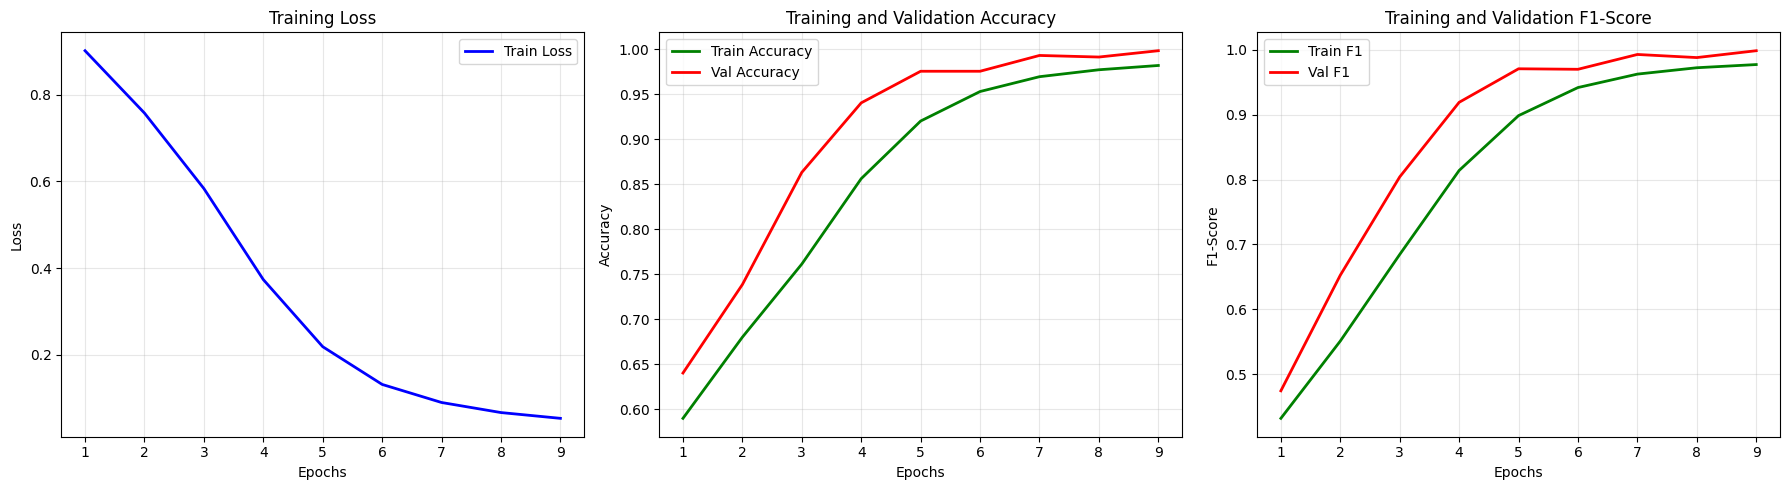

FINAL TRAINING RESULTS
Final Train Loss: 0.0537
Final Train Accuracy: 0.9818
Final Train F1: 0.9772
Final Val Accuracy: 0.9982
Final Val F1: 0.9986
Best Val Accuracy: 0.9982 (epoch 9)
Best Val F1: 0.9986 (epoch 9)


In [ ]:
Trainer.plot_training_history()

In [ ]:
def load_checkpoint(
    ckpt_path: str,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer | None = None,
    map_location: str | torch.device = "cpu"):

    state = torch.load(ckpt_path, map_location=map_location)
    model.load_state_dict(state["model_state_dict"])
    if optimizer is not None and "optimizer_state_dict" in state:
        optimizer.load_state_dict(state["optimizer_state_dict"])
    return state

In [ ]:
# load
ckpt_path = "/content/models/best_model_baseline_classifier_4.pt"
_state = load_checkpoint(ckpt_path, model_baseline, optimizer=None, map_location=DEVICE)\

model.eval()

In [ ]:
from typing import Union
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
import pandas as pd

class InferenceHelper:
    def __init__(self, model, dataloader, tokenizer, device, label_mapping):
        self.model = model
        self.dataloader = dataloader
        self.tokenizer = tokenizer
        self.device = device
        self.model.to(self.device)
        self.model.eval()
        self.label_mapping = label_mapping # {0:0.0, 1:1.0, 2:0.1}

    def _prepare_batch(self, batch):
        """
        Helper method to move a batch to the device.
        """
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            x, y = batch
            if isinstance(x, dict):
                x = {k: v.to(self.device) for k, v in x.items()}
            else:
                x = x.to(self.device)
            y = y.to(self.device)
            return x, y

        raise TypeError(f"Unsupported batch format: {type(batch)}")

    def full_inference(self):
        """ Performs full inference on the entire dataset and provides a classification report. """
        all_trues = []
        all_preds = []

        with torch.no_grad():
            for batch in tqdm(self.dataloader, desc="Full Inference"):
                inputs, labels = self._prepare_batch(batch)
                logits = self.model(**inputs)
                preds = torch.argmax(logits, dim=-1)
                all_preds.extend(preds.detach().cpu().numpy())
                all_trues.extend(labels.detach().cpu().numpy())

        # Convert numerical labels back to original relevance values for reporting
        true_labels = [self.label_mapping[l] for l in all_trues]
        predicted_labels = [self.label_mapping[l] for l in all_preds]

        print("\n" + "=" * 60)
        print("Full Inference Classification Report")
        print("=" * 60)
        print(classification_report(true_labels, predicted_labels, digits=4))
        print("=" * 60)
        return predicted_labels

    def example_inference(self, examples: Union[str, pd.Series, pd.DataFrame], labels: Union[list, None] = None, max_len: int = 512):
        """
        Performs inference on a single example (string) or multiple examples (DataFrame/Series).
        If a string is provided, `labels` can be a list of actual relevances for comparison.
        If a DataFrame/Series is provided, it assumes 'relevance' column for true labels if available.
        """
        self.model.eval()
        results = []

        if isinstance(examples, str):
            processed_examples = [examples]
            if labels and len(labels) == 1:
                true_labels = [self.label_mapping[l] if isinstance(l, int) else l for l in labels]
            else:
                true_labels = [None]
        elif isinstance(examples, pd.Series):
            processed_examples = examples.tolist()
            true_labels = examples.get('relevance', pd.Series([None]*len(examples))).tolist()
        elif isinstance(examples, pd.DataFrame):
            processed_examples = examples.apply(lambda row:
                f"Запрос: {row['Text']}.\nНазвание: {row['name']}\nРубрика: {row['normalized_main_rubric_name_ru']}\nАдрес: {row['address']}\nЦены: {row['prices_summarized']}\nОтзывы: {row['reviews_summarized']}", axis=1
            ).tolist()
            true_labels = examples.get('relevance', pd.Series([None]*len(examples))).tolist()
        else:
            raise ValueError("Examples must be a string, pandas Series, or pandas DataFrame.")

        for i, text in enumerate(processed_examples):
            inputs = self.tokenizer(
                text,
                padding='max_length',
                truncation=True,
                max_length=max_len,
                return_tensors='pt'
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                logits = self.model(**inputs)
                prediction_idx = torch.argmax(logits, dim=-1).item()
                predicted_relevance = self.label_mapping[prediction_idx]

            if true_labels[i] is not None:
                results.append(f"Text: {text[:100]}...\n  True Relevance: {true_labels[i]}, Predicted Relevance: {predicted_relevance}")
            else:
                results.append(f"Text: {text[:100]}...\n  Predicted Relevance: {predicted_relevance}")

        print("\n" + "=" * 60)
        print("Example Inference Results")
        print("=" * 60)
        for res in results:
            print(res + "\n")
        print("=" * 60)
        return predicted_relevance if isinstance(examples, str) else [self.label_mapping[torch.argmax(self.model(**self.tokenizer(p, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt').to(self.device)), dim=-1).item()] for p in processed_examples]

class InferenceHelper:
    def __init__(self, model, dataloader):
        self.model = model
        self.dataloader = dataloader

#